***
# <font color=red>Deploying Machine Learning Models to Oracle Functions </font>

***

**Note: Egress to the public internet is necessary to access the external links inserted in this notebook. Make sure your VCN and subnet are properly configured to access the public internet**

## Overview of this Notebook
This notebook provides a comprehensive overview on model deployment to Oracle Functions.

[Oracle Functions](https://docs.cloud.oracle.com/iaas/Content/Functions/Concepts/functionsoverview.htm) is based on the open source [Fn Project](https://fnproject.io/). Take a look at their website for more details on the `fn` CLI. You will use Cloud Shell to set up the `fn` CLI, build, deploy and invoke a Function.   Cloud Shell is a web-based terminal accessible from the Oracle Cloud Console.  It is free to use, and the Oracle CLI, Functions and Docker are pre-installed.  Cloud Shell comes with 5GB of persistent storage for the home directory, so you can make changes to your home directory and then continue working on your project when you come back to Cloud Shell. You can read more about Cloud Shell [here](https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/cloudshellintro.htm)

## Objectives:
 - <a href='#deploy-with-cloud-shell'>Deploy Functions with Cloud Shell</a>
      - <a href='#tenancy-setup'>OCI Tenancy Setup</a>
      - <a href='#download-model-artifact'>Download Model Artifacts</a>
      - <a href='#set-up-fn-cli'>Set up fn CLI</a>
      - <a href='#create-deploy-invoke-functions'>Create, Deploy, Invoke Functions</a>

<a id='deploy-with-cloud-shell'></a>
## Deploy `Function` with Cloud Shell

In this section we will guide you on the steps to use Cloudshell to deploy `Function`. To access Cloud Shell, log into the Oracle Cloud Console and go to the top right corner. 

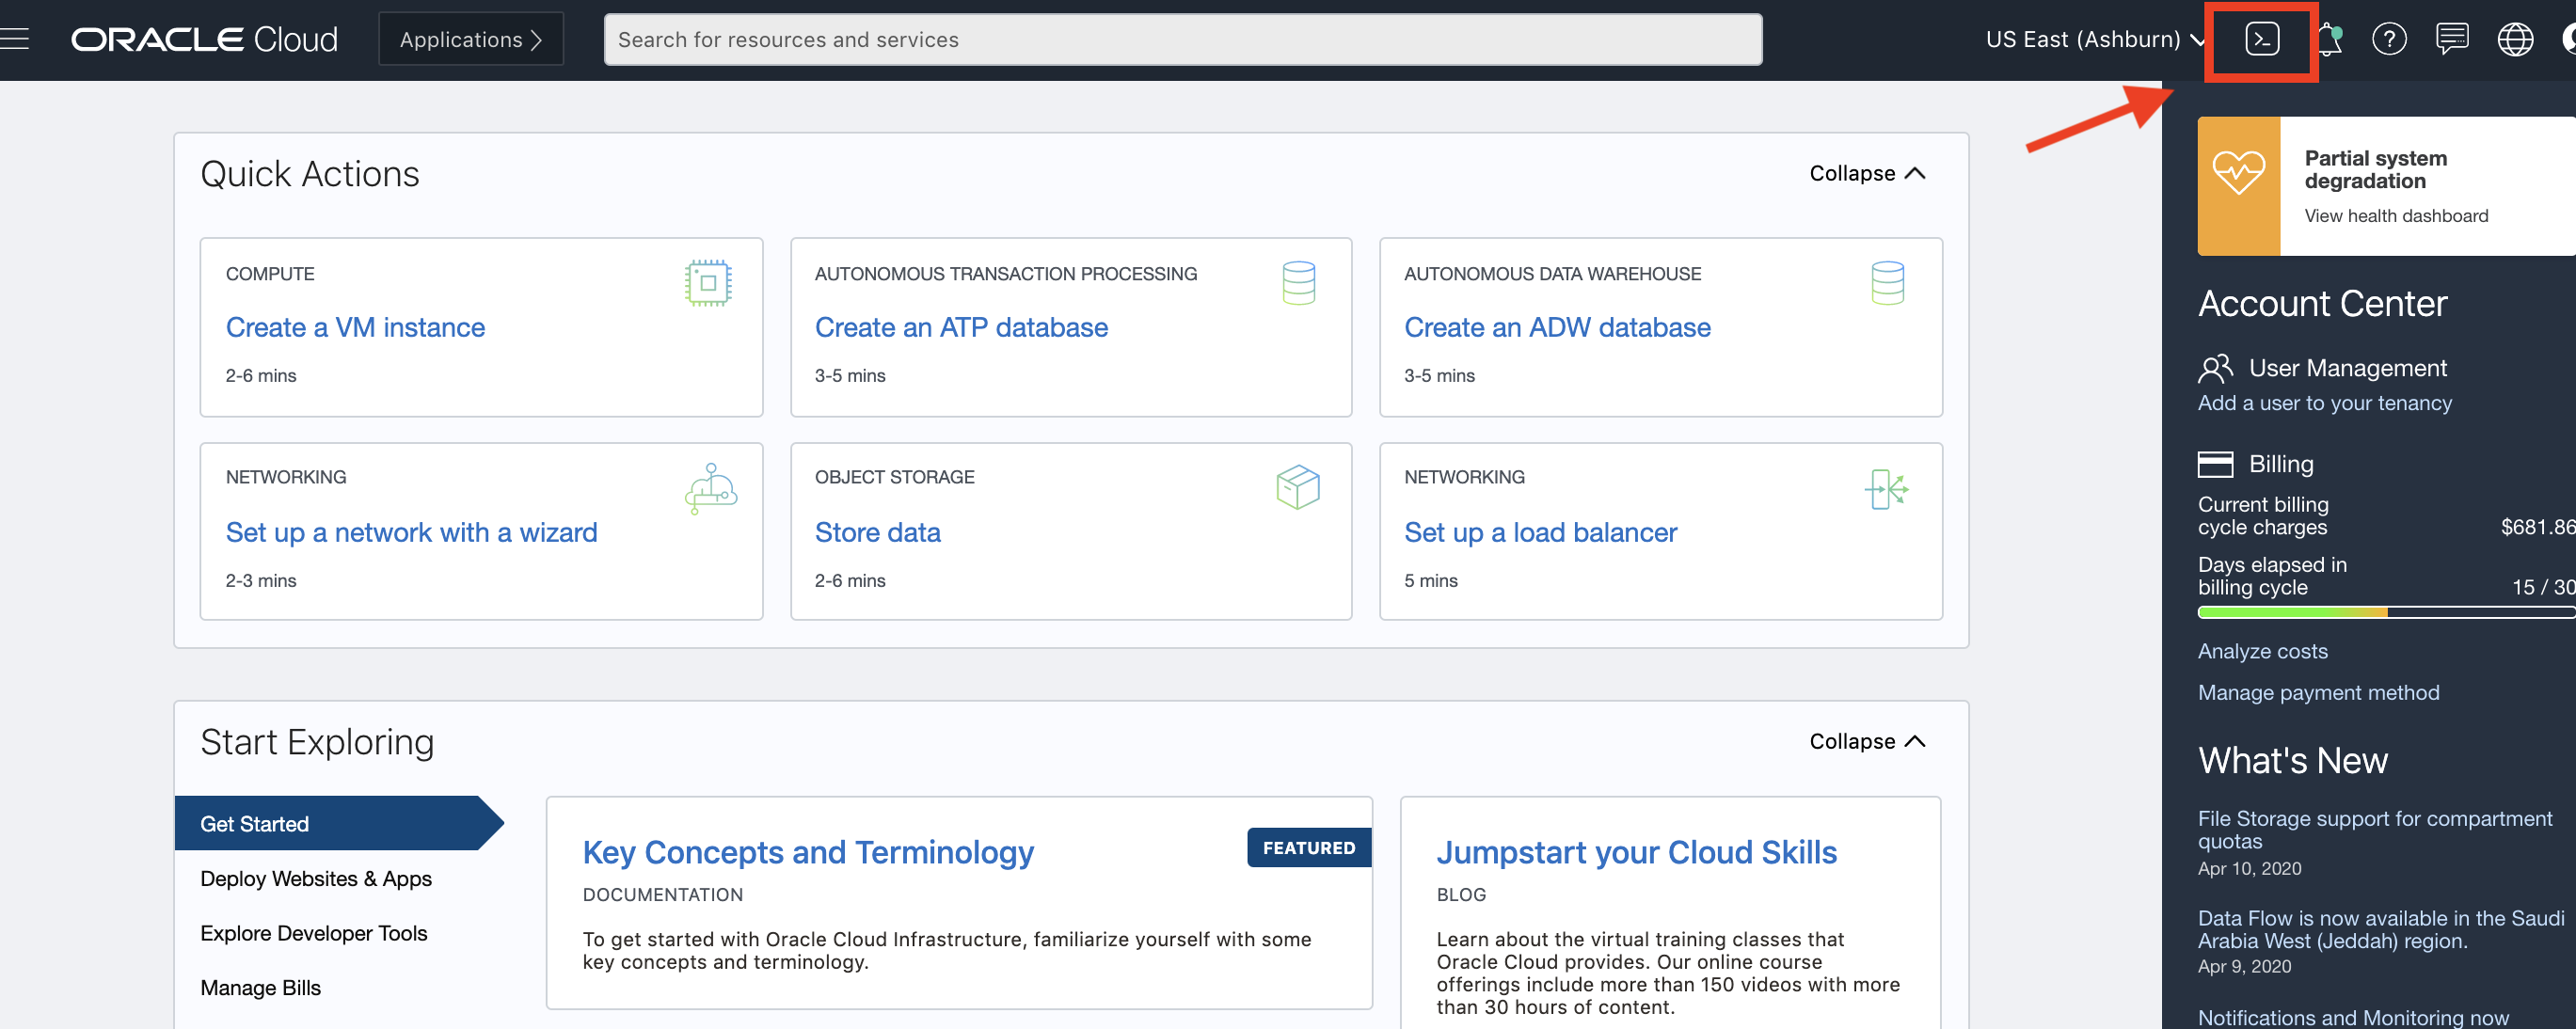

<a id='tenancy-setup'></a>
### OCI Tenancy Setup  

Before deployment, an admin of your OCI tenancy needs to setup the appropriate policies and give your OCI user access to a compartment where the `Function` can be deployed. We have created OCI groups, users, compartments, VCN, and subnets in the previous steps. Here we will create policies for the user group we want to access Oracle Functions and for the Oracle Functions service itself.

Log in to the Console as a tenancy administrator and under Governance and Administration, go to Identity and click Policies and then:

Select the tenancy's root compartment, and create a new policy with the following two policy statements for the Oracle Functions service:

```
Allow service FaaS to read repos in tenancy
```

```
Allow service FaaS to use virtual-network-family in compartment <compartment-name>
```

If one or more Oracle Functions users is not a tenancy administrator, select the tenancy's root compartment and create a new policy with the following policy statements:

```
Allow group <group-name> to manage repos in tenancy
```

```
Allow group <group-name> to read objectstorage-namespaces in tenancy
```

```
Allow group <group-name> to read metrics in compartment <compartment-name>
```

(image placeholder below)

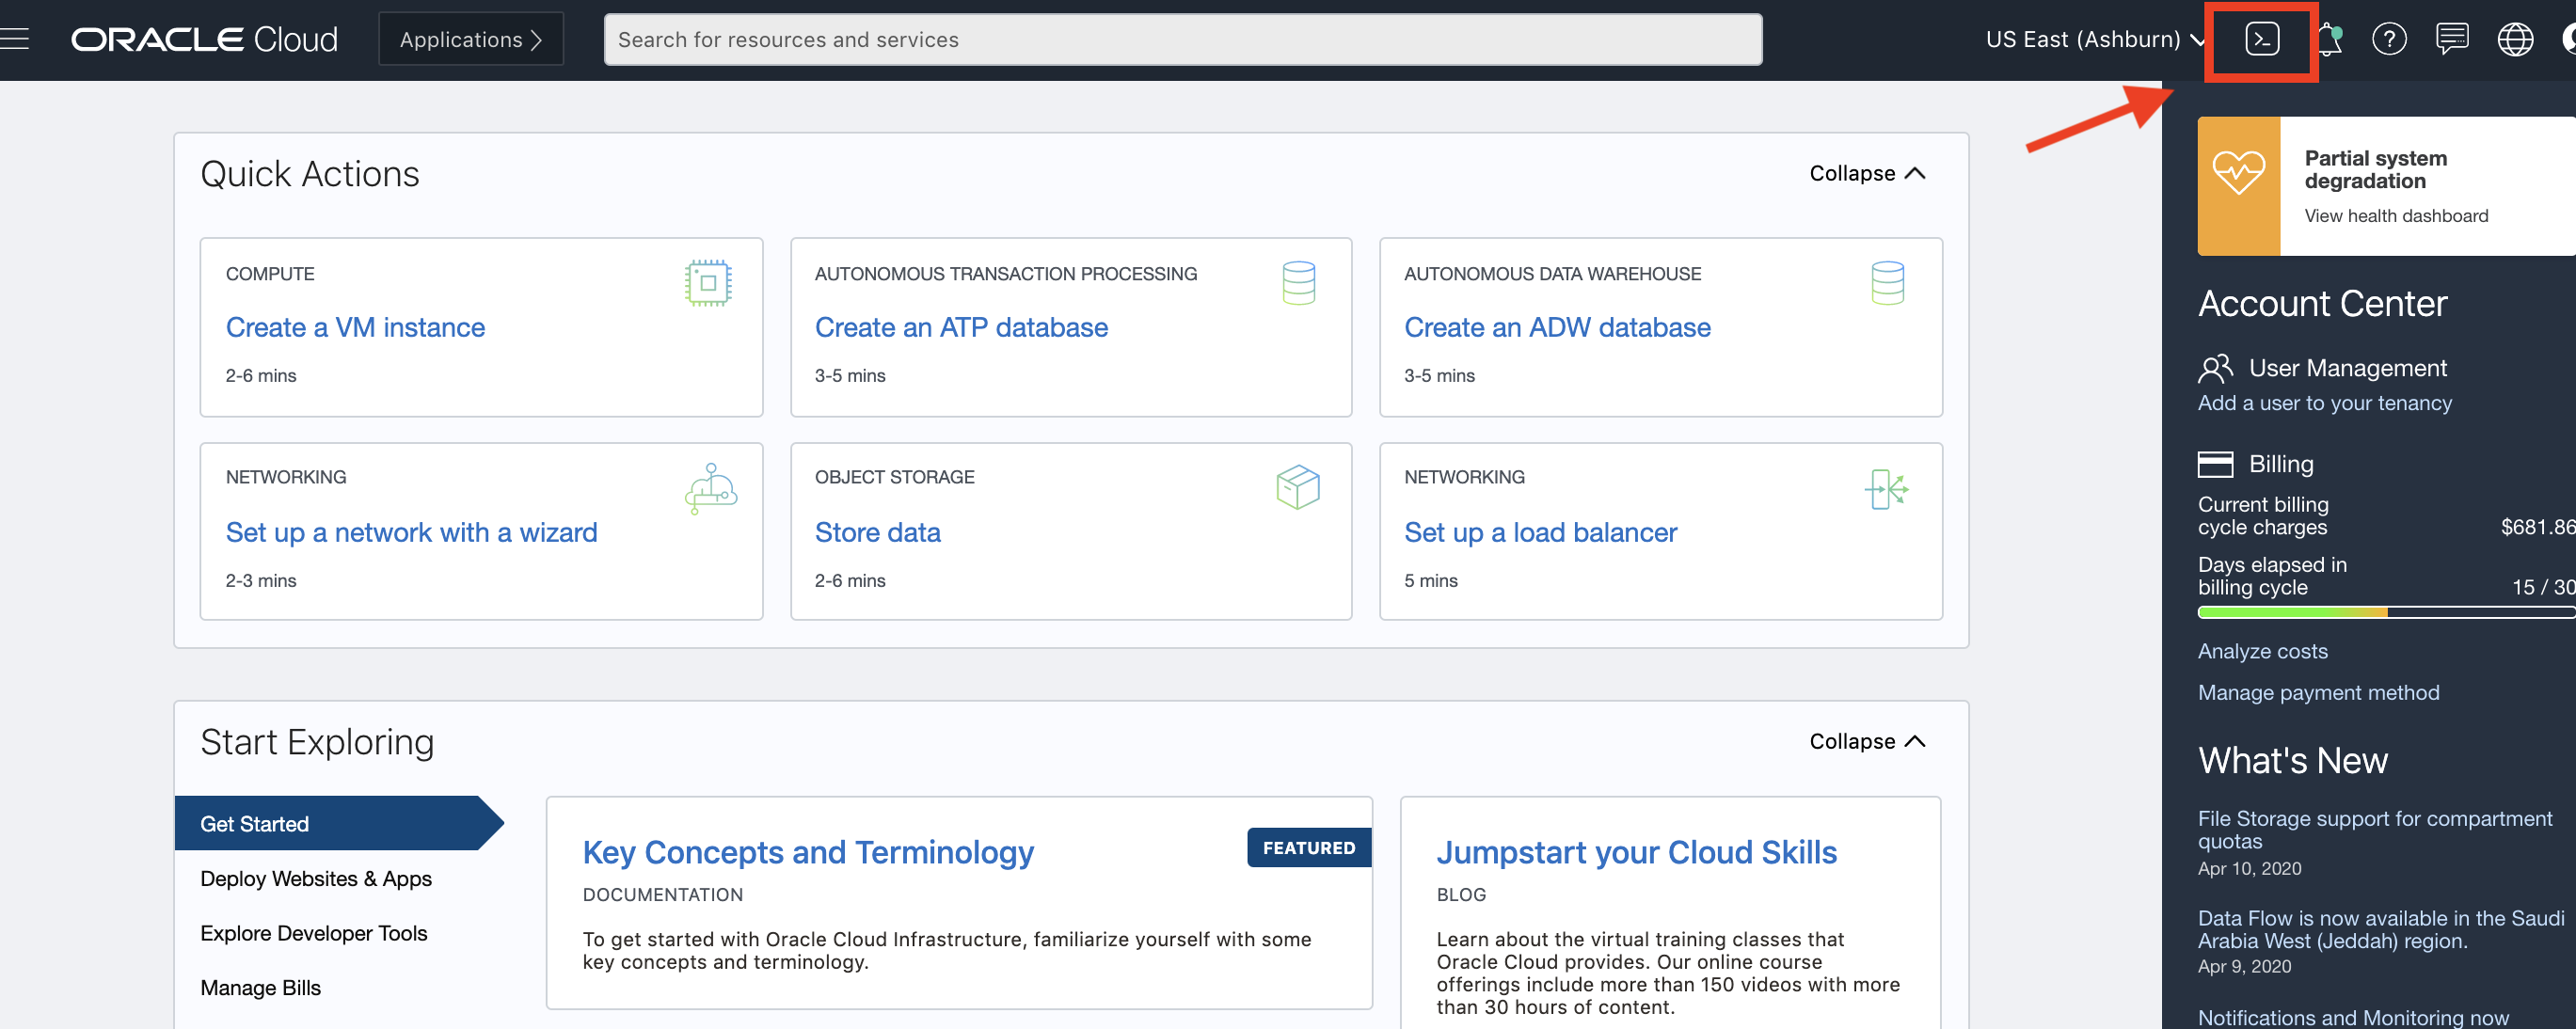

<a id='download-model-artifact'></a>
### Download the model artifact in Cloud Shell

After you open Cloud Shell, create a folder that you want to download the model artifact. Then go to that directory and run
```
oci data-science model get-artifact-content -–model-id <model_ocid> --file <downloaded_artifact_file.zip>

```

and then unzip the downloaded artifact file. 

```
unzip <downloaded_artifact_file.zip>

```

`<downloaded_artifact_file.zip>` is what you want to name the downloaded artifact zip file. And `<model_ocid>` can be found from the OCI console as shown below, or by listing models in the model catalog.

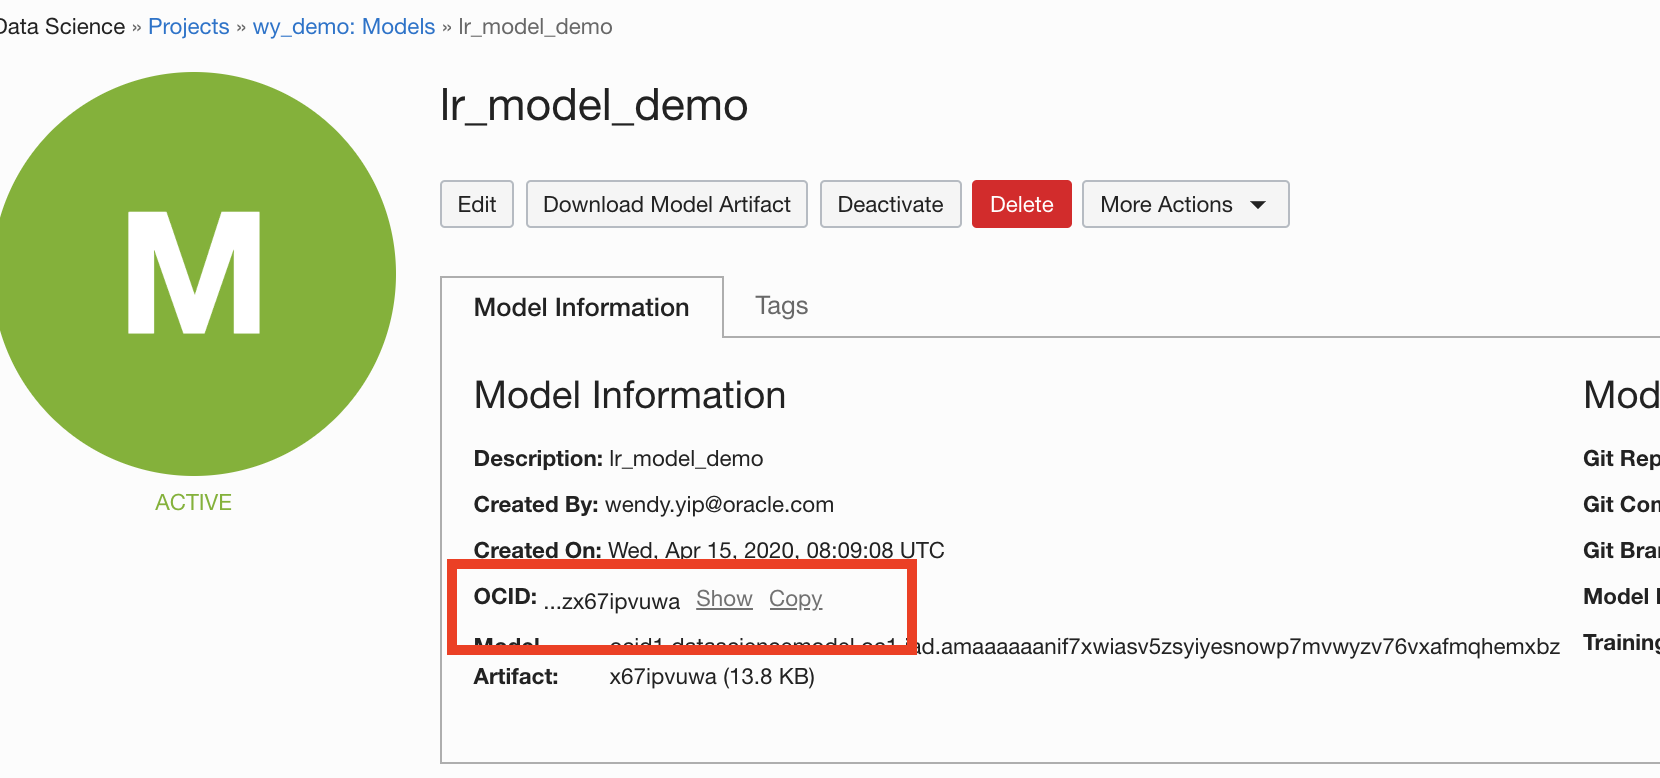

<a id='set-up-fn-cli'></a>
### Set up fn CLI on Cloud Shell

1) Create an application

Log into the OCI Console page, in the tenancy and region where you want to host your function. Go to *Developers Services*, then go to *Functions*.  Create an Application. Select the vcn and subnet you have created for your Functions. 

<br/>


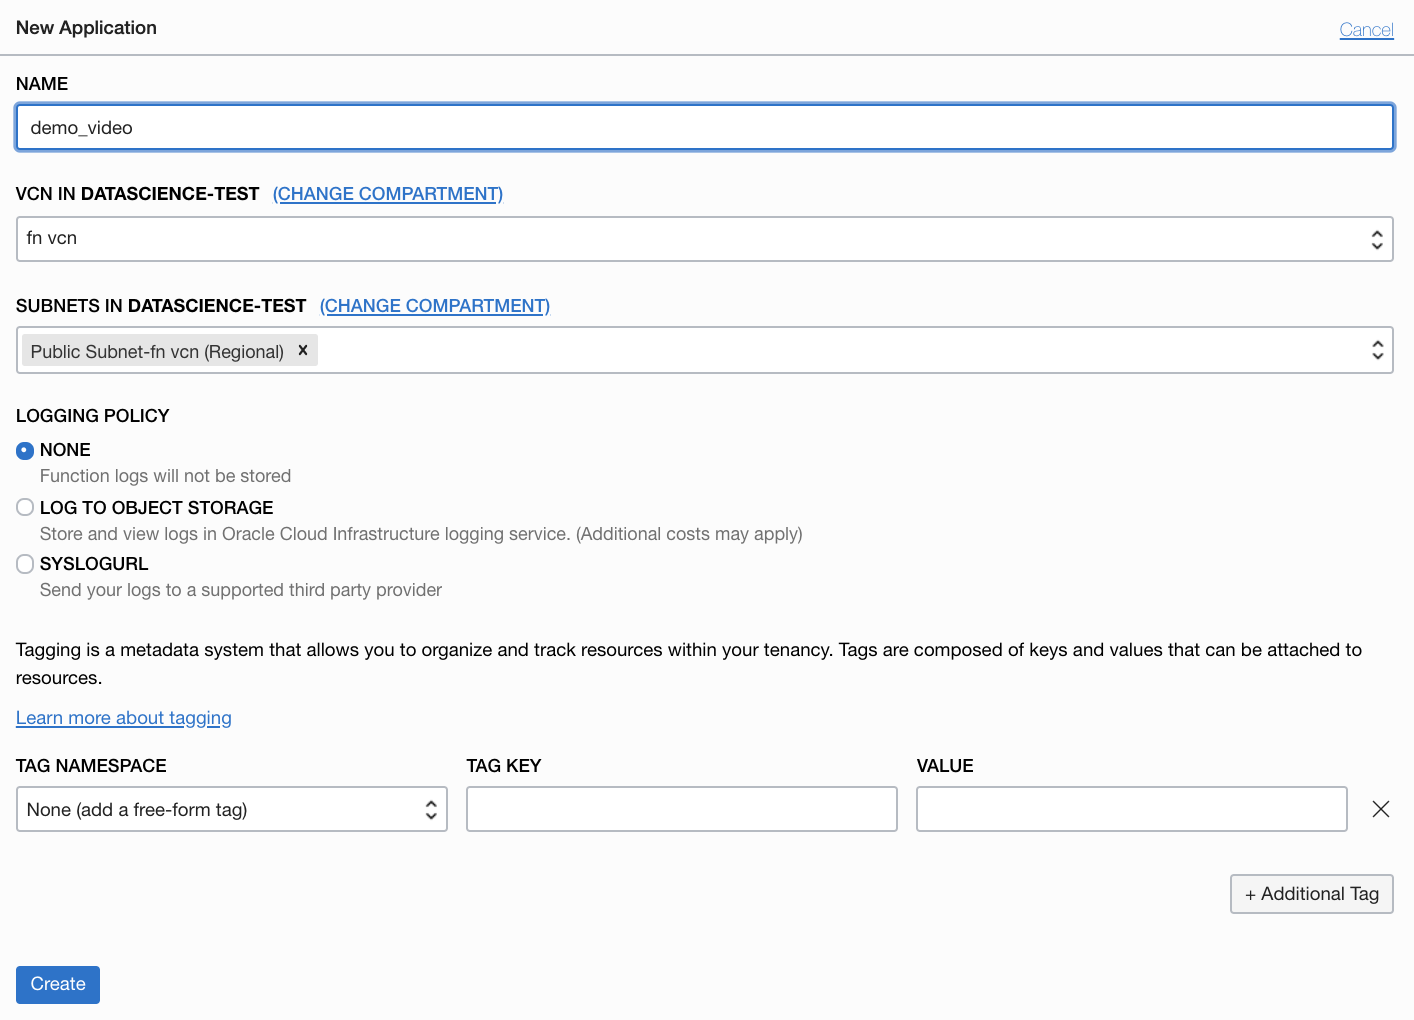

2) Select Cloud Shell Setup

You will see the list of Application that have created.  Click on the name of the Application you want to use.  Then, click on the Getting Started tab and choose the Cloud Shell Setup option.  After you have selected the option, you will see a list of step-by-step instruction on how the set up the fn CLI, along with commands that you can copy and paste into your Cloud Shell terminal to set up the CLI.

<br/>

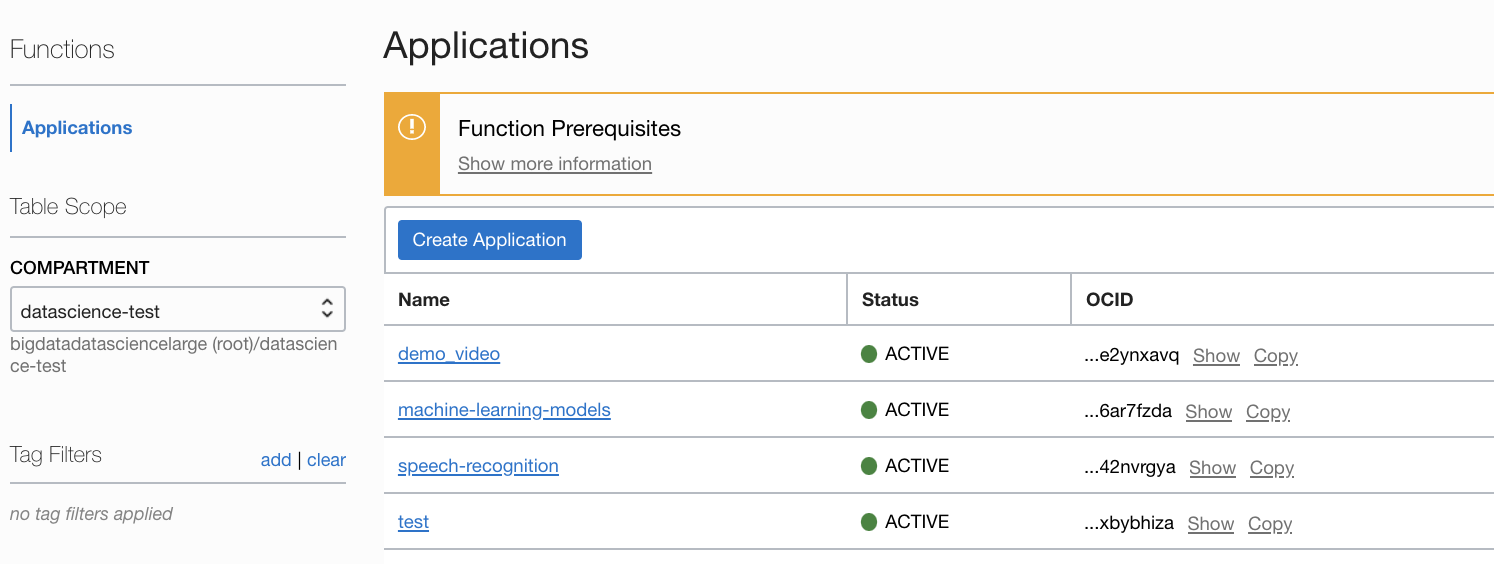

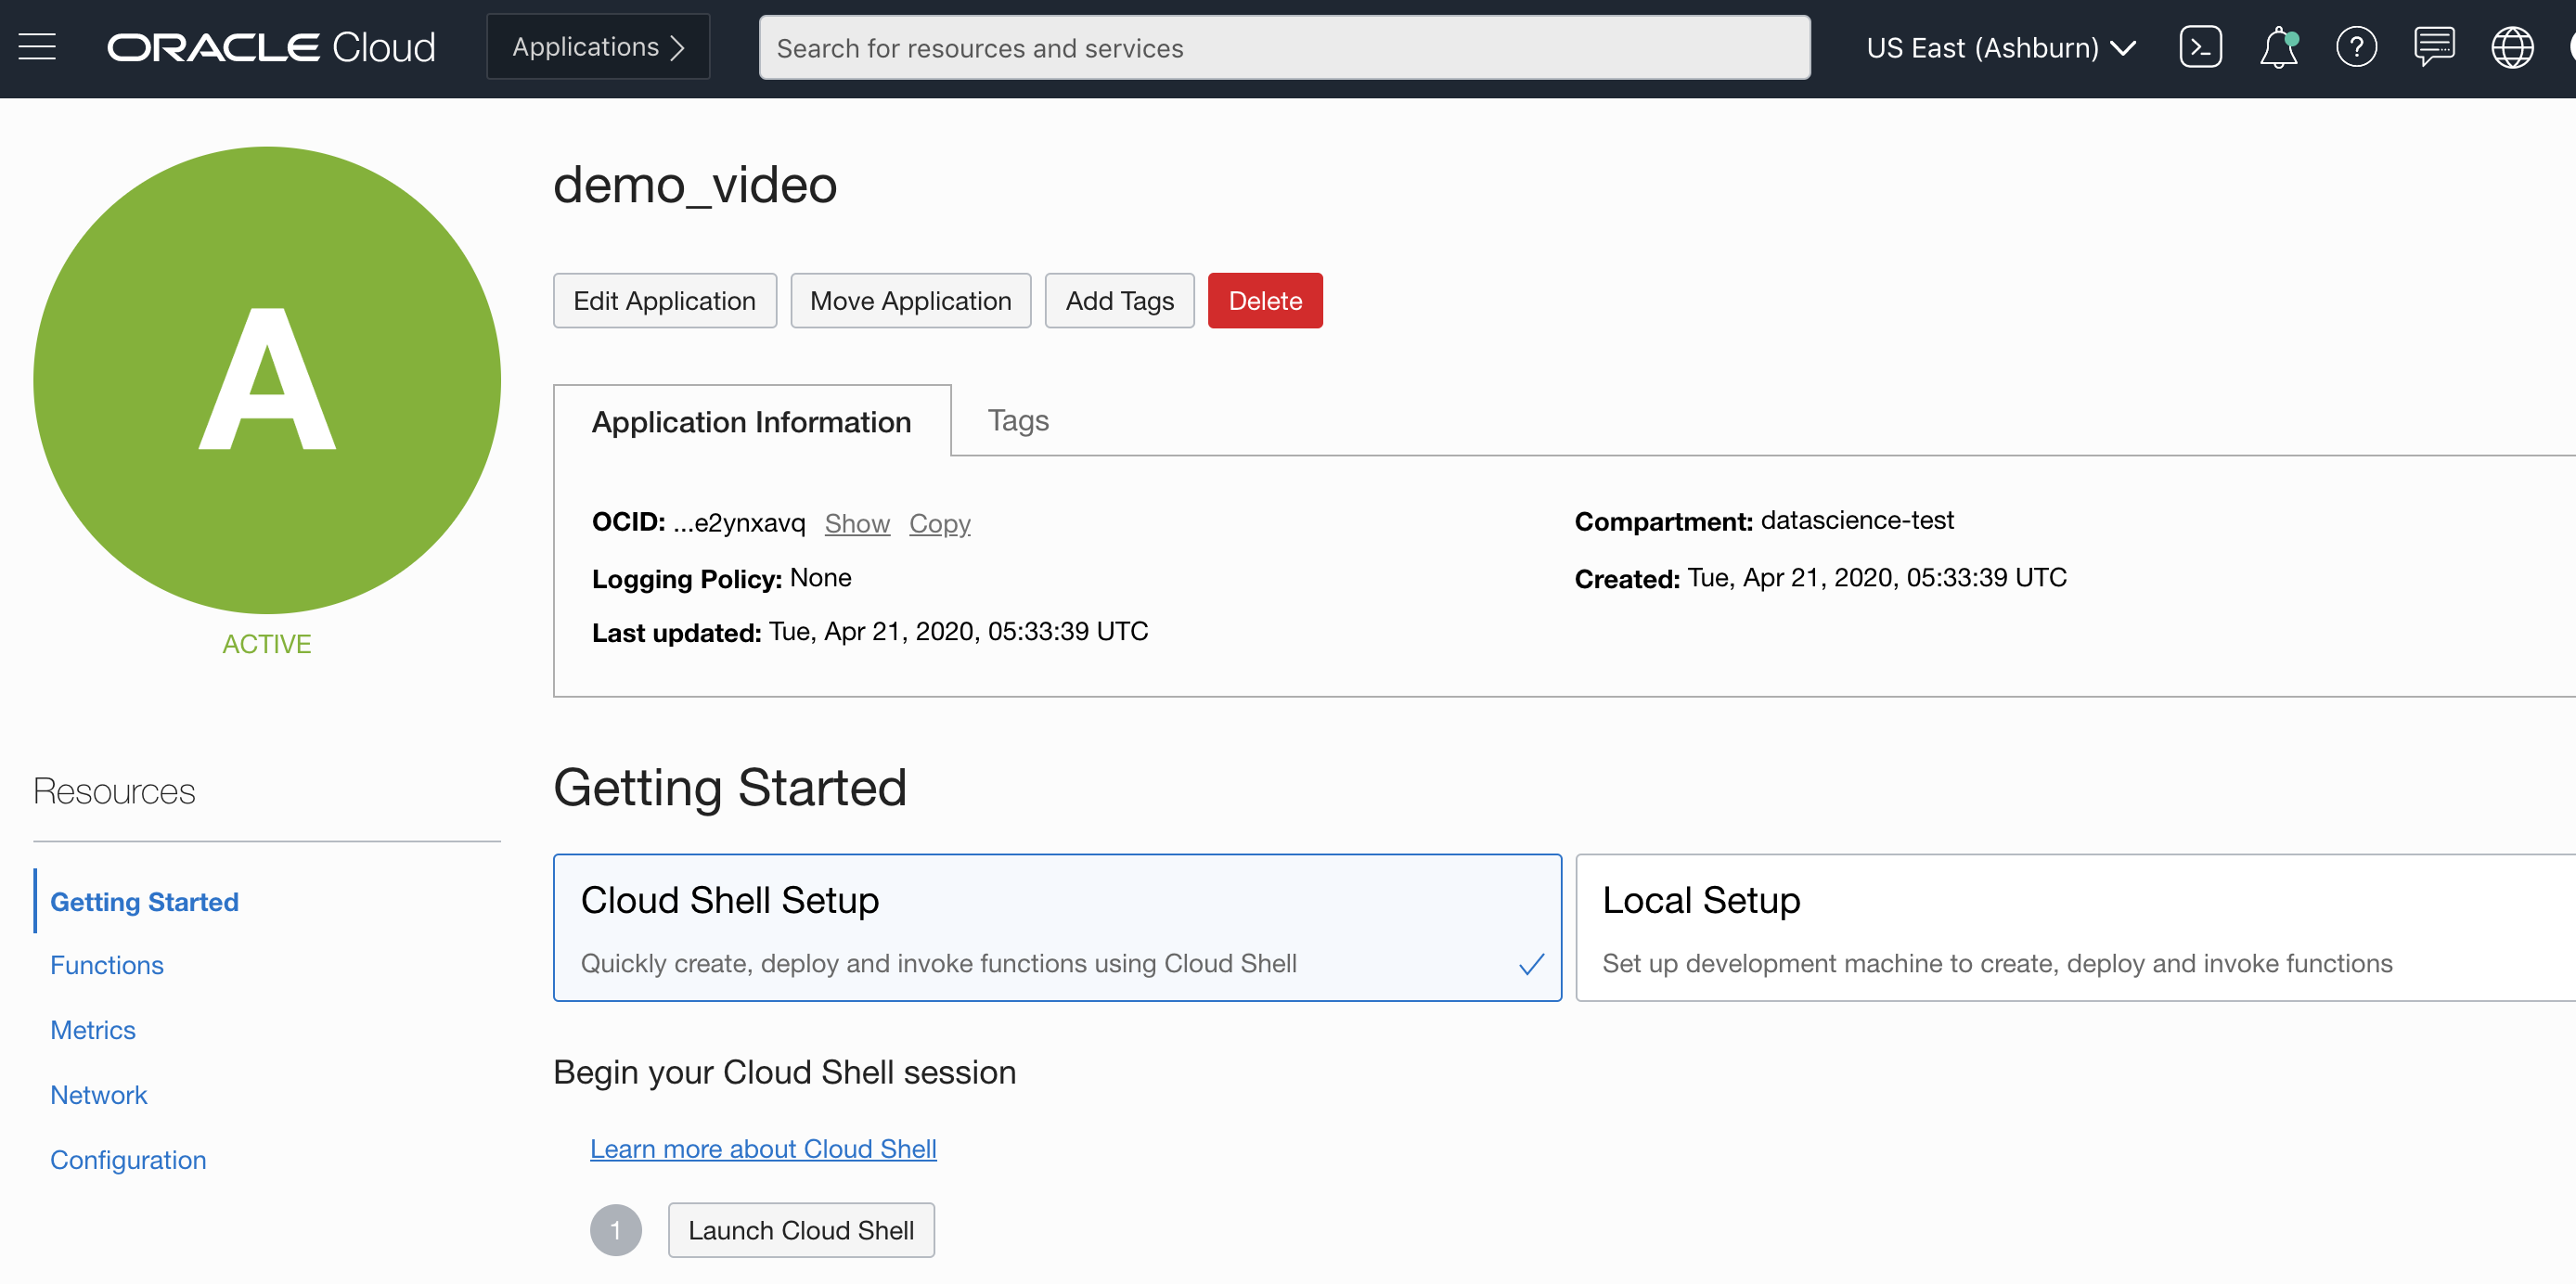

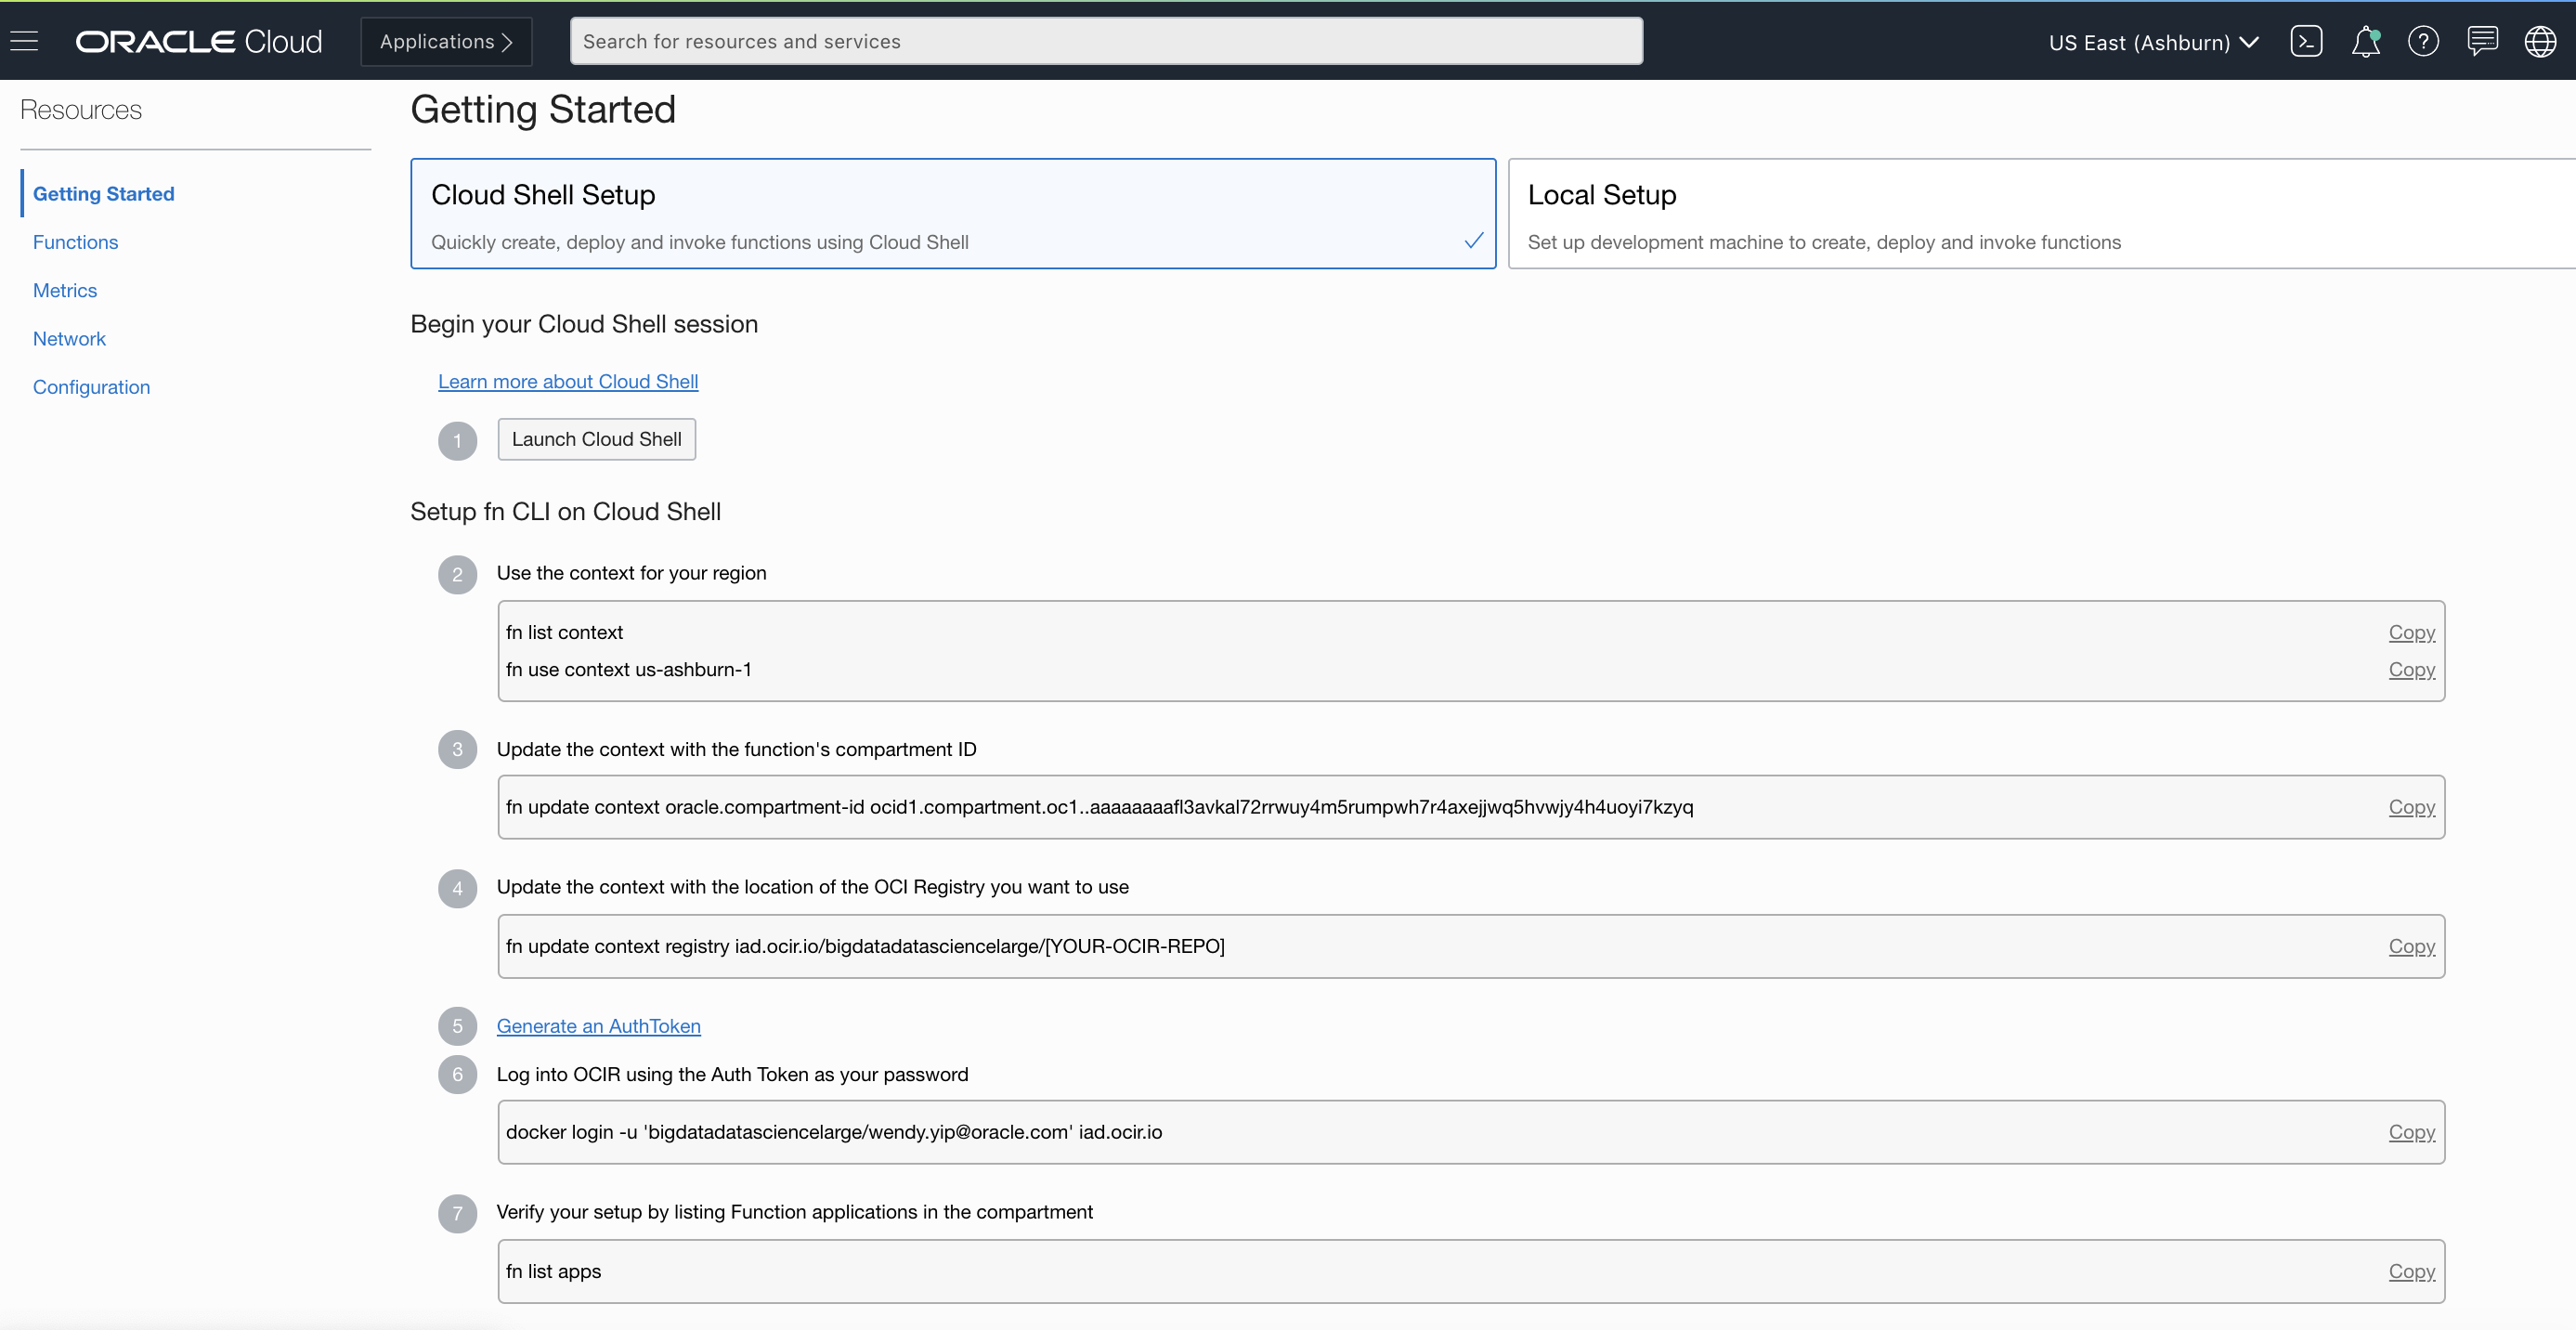



3) Use the context for your region


In your Cloud Shell terminal, you can find out the context available to you using the command 
```
fn list context
```
Use the context for your region.  In the setup instruction, your oci region name is already populated in the instruction command.  You can simply copy and paste the command into your terminal.

```
fn use context <oci-region-name>
```

</br>
4) Update the context with the compartment id you want to use to deploy your Function.  The compartment id of the compartment you are currently using will be populated in the instruction 


```
fn update context oracle.compartment-id <compartment-ocid>

```
</br>

5) Update the context with the location of the OCI Registry you want to use 


```
fn update context registry <region-key>.ocir.io/<objet-store-namespace>/<repo-name>

```

Your `<object-store-namespace>` and `<region-key>` are populated in the command in the step-by-step instruction.  `<repo-name>` is the repository name you want to push your image to. You can specify the name of the repo you want to use.  If the repo has not yet been created, it will be created for you after executing the command.  

`<object-store-namespace>` is the auto-generated Object Storage namespace string of the tenancy where your repositories are created (as shown on the OCI Tenancy Information page).

`<region-key>` is the key of the OCI Registry region where your repositories are created. For example, `<region-key>` for `us-ashburn-1` is `iad`. 

</br>

6) Generate an Auth Token to enable login to Oracle Cloud Infrastructure Registry

You need to create an Auth Token to enable login to Regsitry (OCIR).

Log in to the OCI Console as a functions developer and:

Open the User menu and go to User Settings. On the Auth Tokens page, click Generate Token. 

Enter a meaningful description for the auth token in the Generate Token dialog, and click Generate Token. The new auth token is displayed.

Copy the auth token immediately to a secure location from where you can retrieve it later, because you won't see the auth token again in the Console.

Close the Generate Token dialog.

</br>

7) Log into OCIR using the Auth Token as your password


```
docker login -u ‘object-store-namespace/user-name’ region-key.ocir.io

```
The object storage namespace, user-name and region-key are already populated in the instruction command.

When prompted to enter the password, use the Auth Token you have generated.

(image placeholder below)

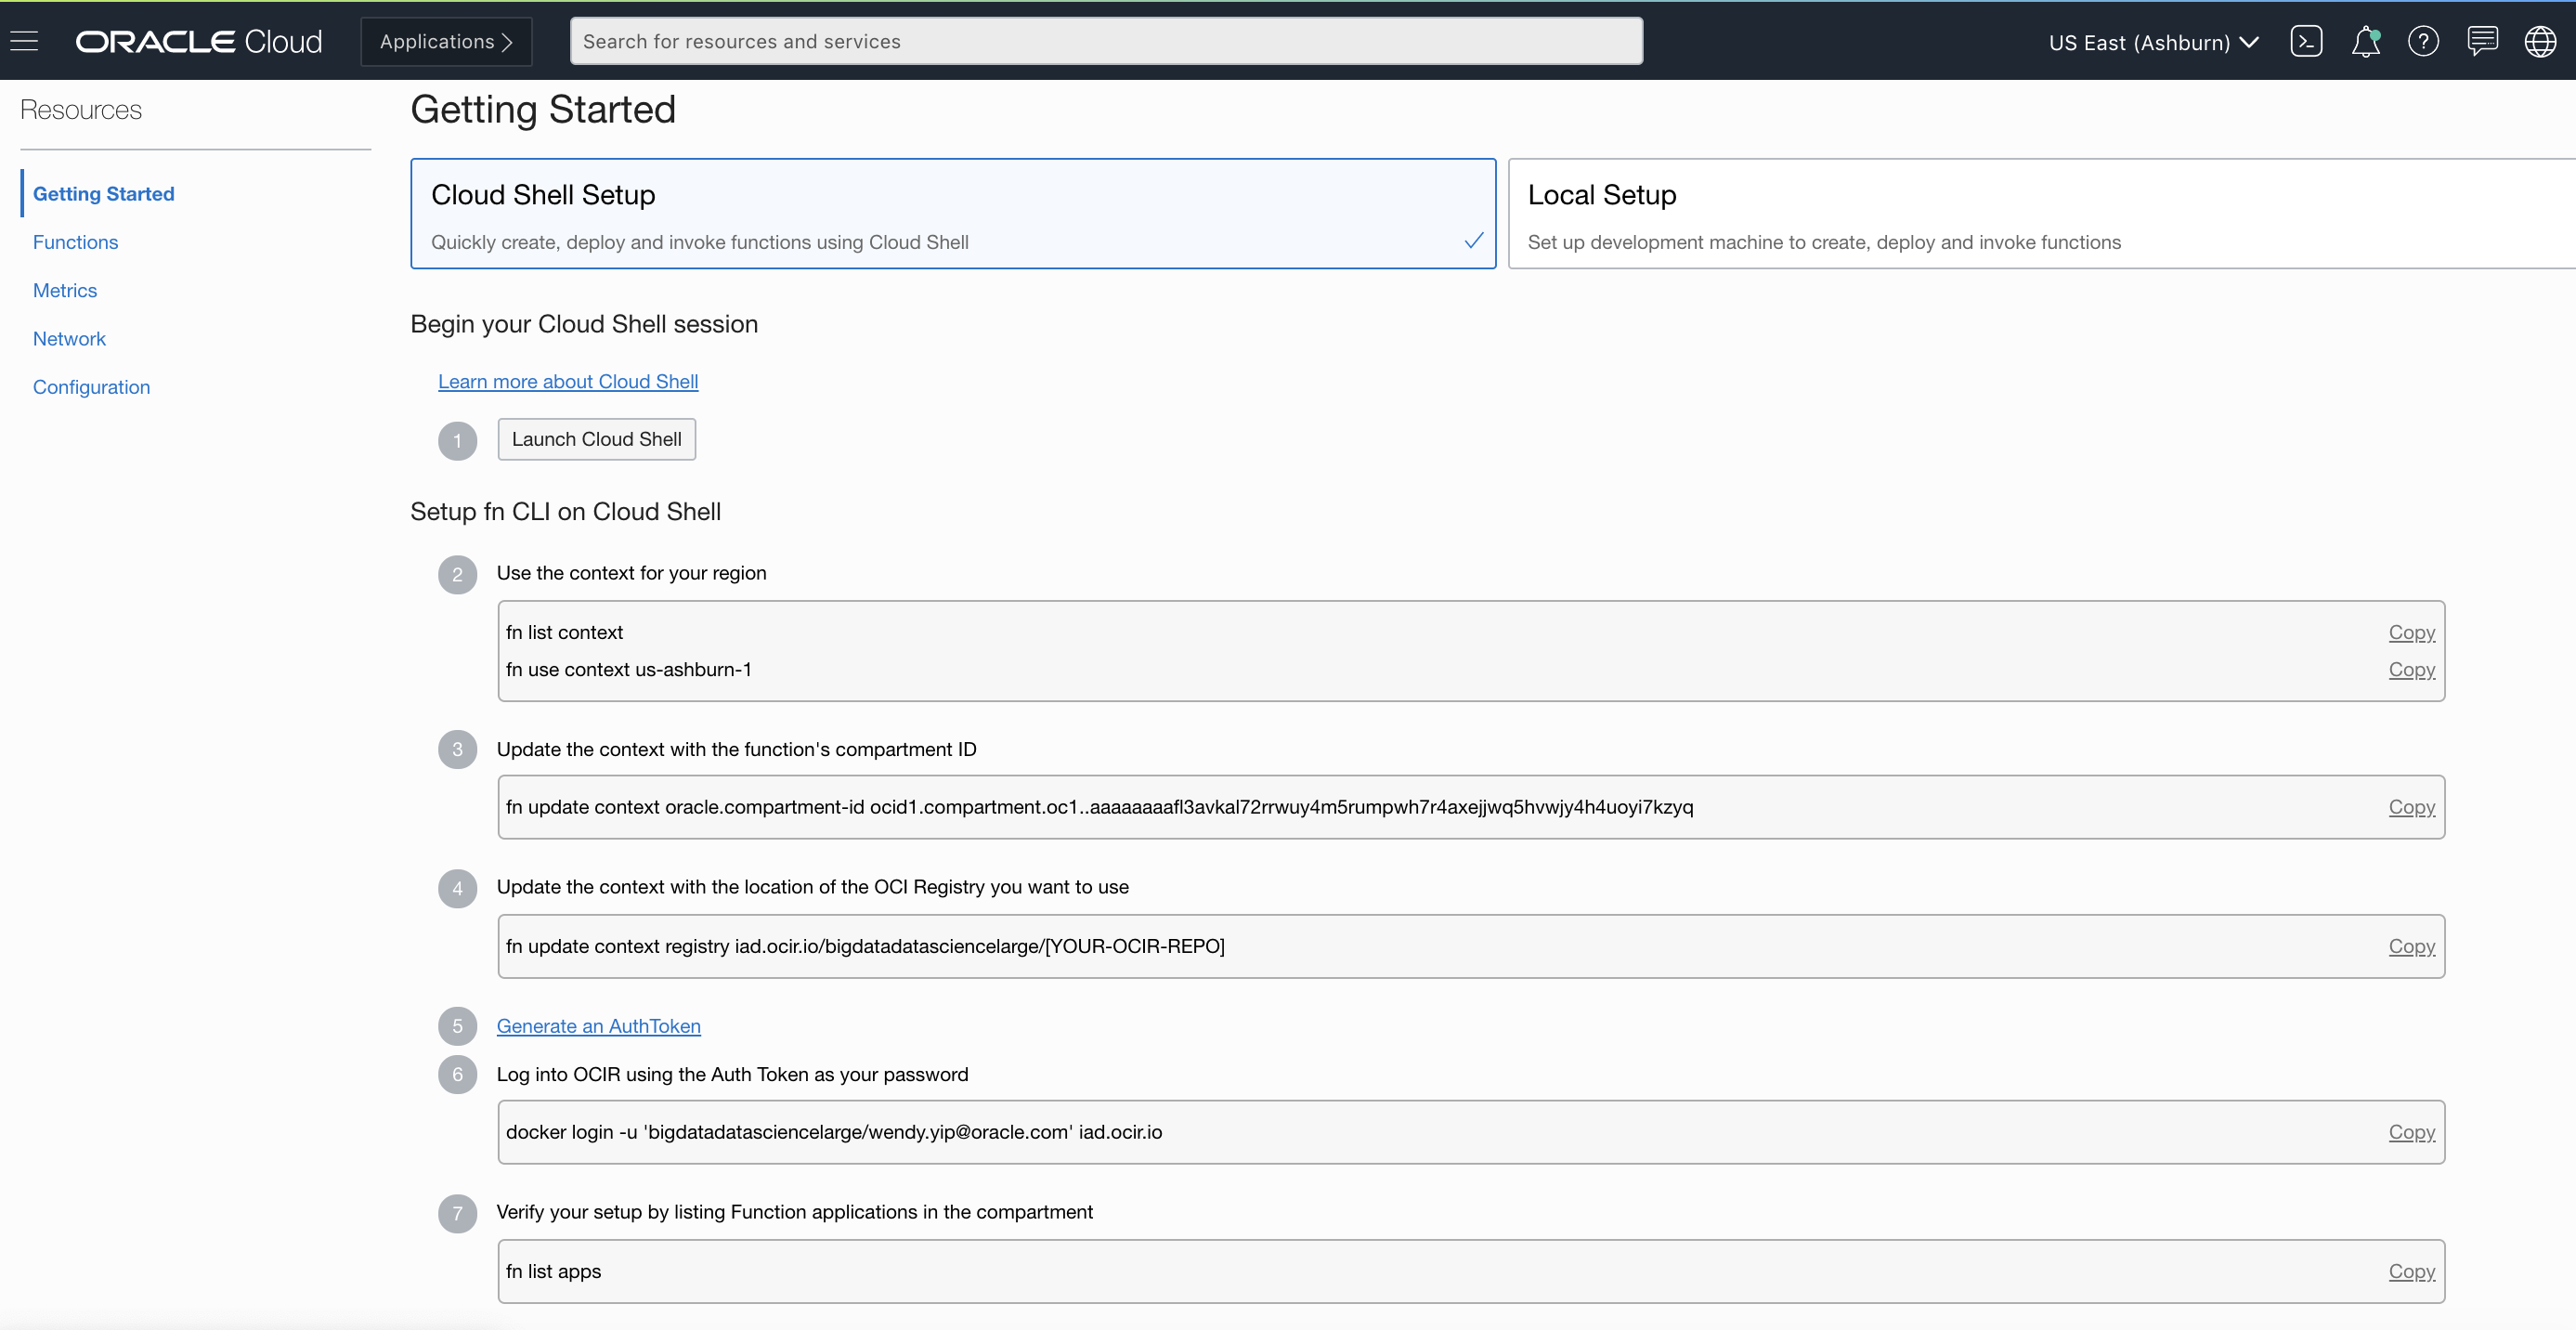

<a id='create-deploy-invoke-functions'></a>
### Create, Deploy and Invoke Functions

8) Deploy your `Function` 

Go inside the `fn-folder`. You will use the `deploy` command which will build your image, push it to the repo in OCIR and deploy the `Function` 

```
fn --verbose deploy --app <my-app>
```

9) Invoke your `Function` 

You can pass a JSON payload to your `Function` (please use the `input` convention described below in the payload.json) using a simple `cat` command. For example below we pass a list of feature vectors stored in the file `payload.json` to `<my-function>`. Do not forget to specify the content type which is `application/json` in most cases: 
```
cat payload.json | fn invoke <my-app> <my-function> --content-type application/json
```



Sample `payload.json`:
```json
{"input":[[0.9426354816951444,10.0,1.4691851561691212,-443.41377583633323,-0.01884418423666756,2.5156476289097847,-9.0,101.0,-9.0,-0.13569659843193554,1000.0, 10.0,0.0,0.0,1.4507967114096254,-43.87337348658269,0.0004781176582166312,3.0990946463672753,-4.668506323375299,-0.1549329356194024,19.421065136359413, 0.203789137870722,-0.0016150491614570614,2.8334756912076617,-0.004230294763510757,10.0,-1.0,16.602457994672683,1.8711181897376987,11.801446013761858, -1.5978704963512458,1.2148721218109126,-407.3669945970512,133.0075252989285,1.2262200162027341,100.0,8.001033298496045,-0.026874430938811675, 1.3678443110500578,1.7197167339866108,0.1435355464405037,1000.0,0.1954810896006457,0.05063792285779614,-2.428815607323977, -4.695494887609295, 109.86208050517756,157.98065903844312]]}
```

Sample output:
```javascript
{
    "prediction": [1.0]
}
```

You can inspect that the `Function` is packaged successfully with the app using `fn inspect` command

```
fn inspect function <my-app> <my-function>
```